In [7]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### 1. Boundary value problem:
#### Bar with uniform charge


### (a)
$$w'' = \frac{S}{EI}w + \frac{qx}{2EI}(x-l), \hspace{5px} 0<x<l$$ 

In [6]:
S = 1000 #charge on the endpoints
E = 3e7 #elastic modulus
I = 625 #moment of inertia
l = 120 #length of bar
n = 100 #number of intervals

h = l/(n+1)
x = [i*h for i in range(0,n+2)] #nodes

N = 101

In [7]:
#solve tridiagonal system
def inverse_tridiagonal(A,b):
    n = len(A)
    x = np.zeros(n)
    for i in range(1,n):
        A[i,i] = A[i,i] - (A[i,i-1]/A[i-1,i-1])*A[i-1,i]
        b[i] = b[i] - (A[i,i-1]/A[i-1,i-1])*b[i-1]
    
    x[n-1] = b[n-1]/A[n-1,n-1]

    for i in range(n-2,1,-1):
        x[i] = (b[i]-A[i,i+1])/A[i,i]

    return x

In [8]:
#construct matrix A
A = np.zeros((n, n))

for i in range(n):
    A[i, i] = -2 - (h ** 2) * S / (E * I)
    if i < n-1:
        A[i+1, i] = 1
    if i > 0:
        A[i-1, i] = 1

    

In [9]:
def r(q, x):
    return q * x * (x - l) / (2 * E * I)

def solve_for_q(k):
    q = 10 ** k
    d = np.zeros(N-1)
    for i in range(0, N-1):
        d[i] = (h ** 2) * r(q, x[i+1])
    sol = np.linalg.solve(A, d)
    y = np.zeros(N+1)
    for i in range(1, N):
        y[i] = sol[i-1]
    return y

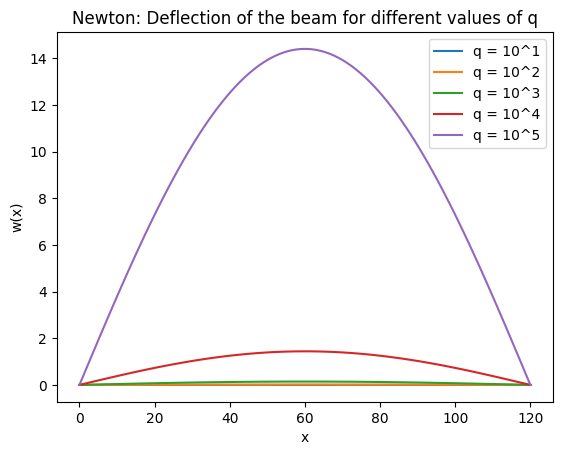

In [10]:
for q in [1, 2, 3, 4, 5]:
    y = solve_for_q(q)
    plt.plot(x, y, label='q = 10^{}'.format(q))
    plt.title('Newton: Deflection of the beam for different values of q')
    plt.xlabel('x')
    plt.ylabel('w(x)')
    plt.legend(loc='upper right')

### (b)
$$w_n'' = [1+(w_n')^2]^{3/2}\left(\frac{S}{EI}w_n + \frac{qx}{2EI}(x-l)\right), \hspace{5px} 0<x<l$$ 

In [11]:
n = 100 #number of intervals

h = l/(n+1)
x = [i*h for i in range(0,n+2)] #nodes

In [12]:
def derivative_newton(u, x):
    u1, u2, z1, z2 = u
    u1 = u2
    u2 = (1+u2**2)**(3/2)*((S/(E*I))*u1 + ((q*x)/(2*E*I))*(x-l))
    z1 = z2
    z2 = (1+u2**2)**(3/2)*(S/(E*I))*z1 + (3/2)*(1+u2**2)**(1/2)*2*u2*((S/(E*I))*u1+((q*x)/(2*E*I))*(x-l))*z2
    return np.array([u1, u2, z1, z2])

def derivative_secant(u, x):
    u1, u2 = u
    u1 = u2
    u2 = (1+u2**2)**(3/2)*((S/(E*I))*u1 + ((q*x)/(2*E*I))*(x-l))
    return np.array([u1, u2])

In [13]:
def runge_kutta(f, y0, t0, h, n):
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(1, n):
        t = t0 + h*i
        k1 = f(y[i-1], t)
        k2 = f(y[i-1] + k1*(h/2), t + h/2)
        k3 = f(y[i-1] + k2*(h/2), t + h/2)
        k4 = f(y[i-1] + k3*h, t + h)
        y[i] = y[i-1] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    return y

def shooting_method_newton(f, t0, h, n, b):
    lmbda_last = np.inf
    lmbda = 0 #initial guess
    y0 = [0, lmbda, 0, 1]
    y = runge_kutta(f, y0, t0, h, n)

    counter = 0
    while abs(lmbda_last - lmbda) > 1e-6:
        lmbda_last = lmbda
        lmbda = lmbda - (y[-1][0] - b)/y[-1][2]
        y0 = [0, lmbda, 0, 1]
        y = runge_kutta(f, y0, t0, h, n)

        counter += 1
    return y, counter

def shooting_method_secant(f, t0, h, n, b):
    t1 = 0.1 #initial guess
    y1 = runge_kutta(f, [0, t1], t0, h, n)
    t2 = t1 + 0.1
    y2 = runge_kutta(f, [0, t2], t0, h, n)
    m1 = y1[-1][0] - b
    m2 = y2[-1][0] - b

    counter = 0
    while abs(t2 - t1) > 1e-6:
        tmp = t2
        t2 = t1 - (t1 - t2)/(m1 - m2)*m1
        t1 = tmp
        y1 = runge_kutta(f, [0, t1], t0, h, n)
        y2 = runge_kutta(f, [0, t2], t0, h, n)
        m1 = y1[-1][0] - b
        m2 = y2[-1][0] - b

        counter += 1
    return y2, counter


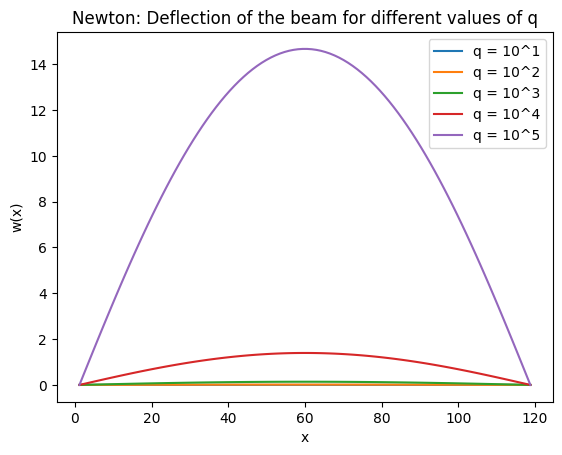

In [14]:
# for different values of q plot the deflection of the beam in the same graph
for exponent in [1, 2, 3, 4, 5]:
    q = 10**exponent
    y, counter = shooting_method_newton(derivative_newton, 0, h, n, 0)
    plt.plot(x[1:-1], y[:,0], label='q = 10^{}'.format(exponent))
    plt.title('Newton: Deflection of the beam for different values of q')
    plt.xlabel('x')
    plt.ylabel('w(x)')
    plt.legend(loc='upper right')

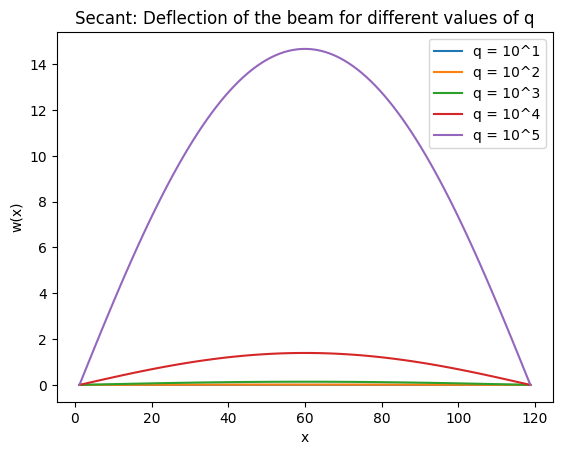

In [15]:
for exponent in [1, 2, 3, 4, 5]:
    q = 10**exponent
    y_secant, counter = shooting_method_secant(derivative_secant, 0, h, n, 0)
    plt.plot(x[1:-1], y_secant[:,0], label='q = 10^{}'.format(exponent))
    plt.title('Secant: Deflection of the beam for different values of q')
    plt.xlabel('x')
    plt.ylabel('w(x)')
    plt.legend(loc='upper right')

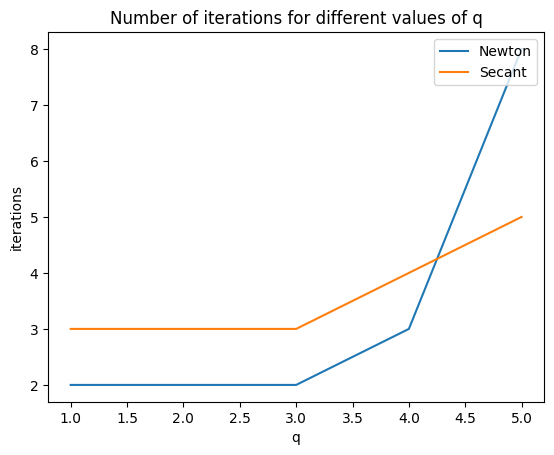

In [16]:
counters_N = []
counters_S = []
for exponent in [1, 2, 3, 4, 5]:
    q = 10**exponent
    y, counterN = shooting_method_newton(derivative_newton, 0, h, n, 0)
    y_secant, counterS = shooting_method_secant(derivative_secant, 0, h, n, 0)

    counters_N.append(counterN)
    counters_S.append(counterS)

plt.plot([1, 2, 3, 4, 5], counters_N, label='Newton')
plt.plot([1, 2, 3, 4, 5], counters_S, label='Secant')
plt.title('Number of iterations for different values of q')
plt.xlabel('q')
plt.ylabel('iterations')
plt.legend(loc='upper right')


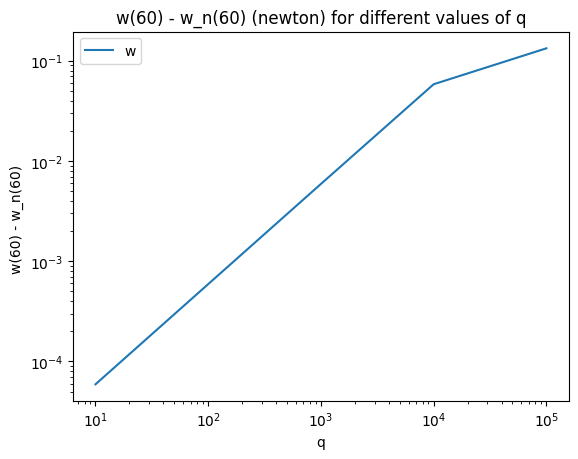

In [17]:
w60 = []
wn60 = []

for exponent in [1, 2, 3, 4, 5]:
    q = 10**exponent
    y_newton, counterN = shooting_method_newton(derivative_newton, 0, h, n, 0)
    y = solve_for_q(exponent)
    w60.append(y[60])
    y_n = y_newton[:,0]
    wn60.append(y_n[60])

diff = np.abs(np.array(w60) - np.array(wn60))
plt.loglog([10, 10**2, 10**3, 10**4, 10**5], diff, label='w')
plt.title('w(60) - w_n(60) (newton) for different values of q')
plt.xlabel('q')
plt.ylabel('w(60) - w_n(60) ')
plt.legend(loc='upper left')

### 2. Boundary value problem:
#### Dirichlet and Neumman conditions


### (a)

In [53]:
from scipy.integrate import quad
from math import exp, e
import numpy as np
from scipy.linalg import solve
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline

In [54]:
def y_analytical(x):
    return x * (exp(x) - e)

def f(x):
    return (x - 1) - (x + 1) * exp(-(x - 1))

def g(x):
    return exp(-x)

def phi(x, i, xs, h):
    if i > 0 and i < len(xs) - 1:
        if xs[i - 1] <= x <= xs[i]:
            return (x - xs[i - 1]) / h
        elif xs[i] <= x <= xs[i + 1]:
            return (xs[i + 1] - x) / h
    return 0

def phiprime(x, i, xs, h):
    if i > 0 and i < len(xs) - 1:
        if xs[i - 1] <= x <= xs[i]:
            return 1 / h
        elif xs[i] <= x <= xs[i + 1]:
            return -1 / h
    return 0

def generate_bspline_basis(knots, degree=3):
    n = len(knots)
    t = np.concatenate(([knots[0]] * degree, knots, [knots[-1]] * degree))
    basis = [BSpline(t, (np.eye(n + degree - 1)[i]), degree) for i in range(degree, n - 1)]
    return basis

In [55]:
hs = [0.2, 0.1, 0.05, 0.01]
errors_piecewise = []
errors_bspline = []

for h in hs:
    N = int(1 / h)
    xs = [h * i for i in range(0, N + 1)]

    A_piecewise = np.zeros((N + 1, N + 1))
    l_piecewise = np.zeros(N + 1)

    for i in range(1, N):
        for j in range(1, N):
            func_k = lambda x: phiprime(x, i, xs, h) * phiprime(x, j, xs, h) * g(x) + g(x) * phi(x, i, xs, h) * phi(x, j, xs, h)
            A_piecewise[i, j], _ = quad(func_k, xs[i - 1], xs[i + 1])

        func_f = lambda x: f(x) * phi(x, i, xs, h)
        l_piecewise[i], _ = quad(func_f, xs[i - 1], xs[i + 1])

    A_piecewise = A_piecewise[1:-1, 1:-1]
    l_piecewise = l_piecewise[1:-1]

    delta = solve(A_piecewise, l_piecewise)
    delta = np.hstack([[0], delta, [0]])

    y_exact_values = np.array([y_analytical(x) for x in xs])
    error_max_piecewise = np.max(np.abs(delta - y_exact_values))
    errors_piecewise.append(error_max_piecewise)

    knots = np.linspace(0, 1, N + 1)
    basis = generate_bspline_basis(knots, 3)
    N_bspline = len(basis)

    A_bspline = np.zeros((N_bspline, N_bspline))
    b_bspline = np.zeros(N_bspline)

    for i in range(N_bspline):
        for j in range(N_bspline):
            integrand = lambda x: (basis[i].derivative()(x) * basis[j].derivative()(x) * g(x) + basis[i](x) * basis[j](x) * g(x))
            A_bspline[i, j] = quad(integrand, 0, 1)[0]

        b_bspline[i] = quad(lambda x: f(x) * basis[i](x), 0, 1)[0]

    np.fill_diagonal(A_bspline, A_bspline.diagonal() + 1e-5)
    coeffs = solve(A_bspline, b_bspline)

    xs_fine = np.linspace(0, 1, 100)
    ys_bspline = np.array([sum(c * b(x) for c, b in zip(coeffs, basis)) for x in xs_fine])
    exact_ys = np.array([y_analytical(x) for x in xs_fine])
    error_max_bspline = np.max(np.abs(ys_bspline - exact_ys))
    errors_bspline.append(error_max_bspline)

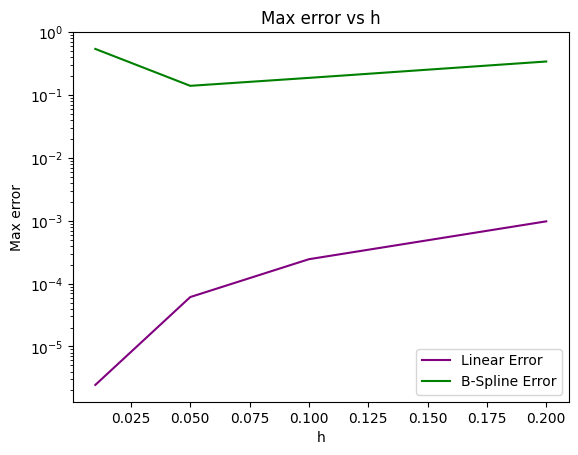

In [56]:
plt.figure()
plt.plot(hs, errors_piecewise, 'purple', label='Linear Error')
plt.plot(hs, errors_bspline, 'green', label='B-Spline Error')
plt.yscale('log')
plt.xlabel('h')
plt.ylabel('Max error')
plt.title('Max error vs h')
plt.legend()
plt.show()

### (b)

In [57]:
def y_analytical(x):
    return x * (exp(x) - e)

def f(x):
    return (x - 1) - (x + 1) * exp(-(x - 1))

def g(x):
    return exp(-x)

def phi(x, i, xs, h):
    if i > 0 and i < len(xs) - 1:
        if xs[i - 1] <= x <= xs[i]:
            return (x - xs[i - 1]) / h
        elif xs[i] <= x <= xs[i + 1]:
            return (xs[i + 1] - x) / h
    return 0

def phiprime(x, i, xs, h):
    if i > 0 and i < len(xs) - 1:
        if xs[i - 1] <= x <= xs[i]:
            return 1 / h
        elif xs[i] <= x <= xs[i + 1]:
            return -1 / h
    return 0

def generate_bspline_basis(knots, degree=3):
    n = len(knots)
    t = np.concatenate(([knots[0]] * degree, knots, [knots[-1]] * degree))
    basis = [BSpline(t, (np.eye(n + degree - 1)[i]), degree) for i in range(degree, n - 1)]
    return basis

In [58]:
hs = [0.2, 0.1, 0.05,0.01]
errors_piecewise = []
errors_bspline = []

for h in hs:
    N = int(1 / h)
    xs = [h * i for i in range(0, N + 1)]

    # Piecewise Linear Basis
    A_piecewise = np.zeros((N + 1, N + 1))
    l_piecewise = np.zeros(N + 1)

    for i in range(1, N):
        for j in range(1, N):
            func_k = lambda x, i=i, j=j: phiprime(x, i, xs, h) * phiprime(x, j, xs, h) * g(x) + g(x) * phi(x, i, xs, h) * phi(x, j, xs, h)
            A_piecewise[i, j], _ = quad(func_k, xs[i - 1], xs[i + 1])

        func_f = lambda x, i=i: f(x) * phi(x, i, xs, h)
        l_piecewise[i], _ = quad(func_f, xs[i - 1], xs[i + 1])

    # Apply Neumann boundary conditions, using regularization
    A_piecewise[0, 0] = A_piecewise[-1, -1] = 1 / h + 1e-10
    l_piecewise[0] = 0  # Neumann condition y'(0) = 0
    l_piecewise[-1] = e  # Neumann condition y'(1) = e

    delta = solve(A_piecewise, l_piecewise)

    y_exact_values = np.array([y_analytical(x) for x in xs])
    error_max_piecewise = np.max(np.abs(delta - y_exact_values))
    errors_piecewise.append(error_max_piecewise)

    # B-Spline Basis
    knots = np.linspace(0, 1, N + 1)
    basis = generate_bspline_basis(knots, 3)
    N_bspline = len(basis)

    A_bspline = np.zeros((N_bspline, N_bspline))
    b_bspline = np.zeros(N_bspline)

    for i in range(N_bspline):
        for j in range(N_bspline):
            integrand = lambda x, i=i, j=j: (basis[i].derivative()(x) * basis[j].derivative()(x) * g(x) + basis[i](x) * basis[j](x) * g(x))
            A_bspline[i, j] = quad(integrand, 0, 1)[0]

        b_bspline[i] = quad(lambda x, i=i: f(x) * basis[i](x), 0, 1)[0]

    A_bspline[0, 0] += 1e-10
    A_bspline[-1, -1] += 1e-10
    b_bspline[0] += 0
    b_bspline[-1] += e

    np.fill_diagonal(A_bspline, A_bspline.diagonal() + 1e-5)
    coeffs = solve(A_bspline, b_bspline)

    xs_fine = np.linspace(0, 1, 100)
    ys_bspline = np.array([sum(c * b(x) for c, b in zip(coeffs, basis)) for x in xs_fine])
    exact_ys = np.array([y_analytical(x) for x in xs_fine])
    error_max_bspline = np.max(np.abs(ys_bspline - exact_ys))
    errors_bspline.append(error_max_bspline)

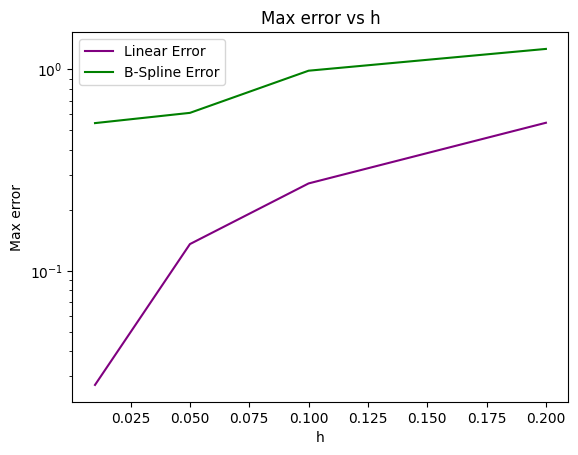

In [60]:
plt.figure()
plt.plot(hs, errors_piecewise, 'purple', label='Linear Error')
plt.plot(hs, errors_bspline, 'green', label='B-Spline Error')
plt.yscale('log')
plt.xlabel('h')
plt.ylabel('Max error')
plt.title('Max error vs h')
plt.legend()
plt.show()

### 3. Call Option Pricing using Black-Scholes equation
#### Crank-Nicholson method


In [18]:
# problem parameters
sigma = 0.15
r = 0.05
T = 0.5
K = 50
s_m = 100

#grid paramaters
h = 0.1
k = 0.001

In [19]:
#grid
I = int(s_m/h) 
x = [i*h for i in range(0,I+1)] #nodes

N = int(T/k)
t = [i*k for i in range(0,N+1)] #nodes

In [20]:
u = np.zeros((I, N))

#boundary conditions
for i in range(0,I):
    u[i][0] = max(i * h - K , 0)

for i in range(0,N):
    u[-1][i] = s_m - K * np.exp(-r * (T - i * k))

In [21]:
#construct matrix A
A = np.zeros((I,I))

#boundary conditions
A[0,0] = 1
A[0,1] = 0
A[I-1,I-1] = 1
A[I-1,I-2] = 0

#interior points
for i in range(1,I-1):
    a = (1/2) * sigma**2 * (i * h)**2
    b = r * (i * h) 
    c = -r
    A[i,i-1] = - (2*k*a + k*h*b)
    A[i,i] = 4 * h**2 + 4 * k * a - 2 * h**2 * k * c
    A[i,i+1] = - (2 * k * a - k * h * b)

A_inv = np.linalg.inv(A)

In [22]:
def CN(A, u, h, k, a, b, c, s_m, K, I, N):
    for n in range(0,N-1):

        D = np.zeros((I))

        #boundary conditions
        D[0] = 0
        D[I-1] = s_m - K

        #interior points
        for i in range(1,I-1):
            a = (1/2) * sigma**2 * (i * h)**2
            b = r * (i * h) 
            c = -r

            D[i] = (2 * k * a - k * h * b)*u[i+1,n] + (4 * h**2 - 4*k*a + 2*h**2*k*c)*u[i,n] + (2*k*a + k*h*b)*u[i-1,n]
        
        u[:,n+1] = A_inv@D
    
    return u

In [23]:
value = CN(A, u, h, k, a, b, c, s_m, K, I, N)

Text(0.5, 1.0, 'V(s,0): k=0.001, h=0.1')

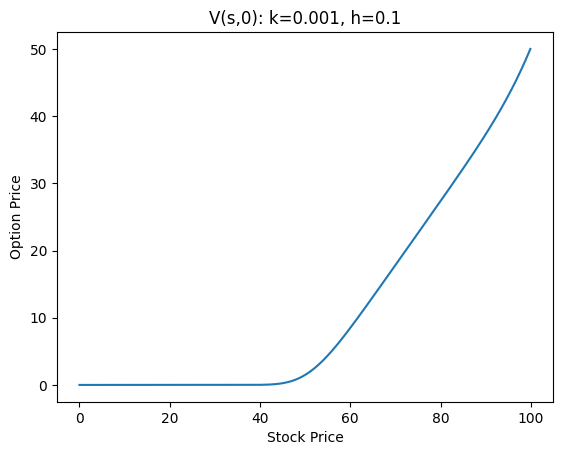

In [25]:
plt.plot(x[0:-1], value[:,-1])
plt.ylabel('Option Price')
plt.xlabel('Stock Price')
plt.title('V(s,0): k={k}, h={h}'.format(k=k, h=h))


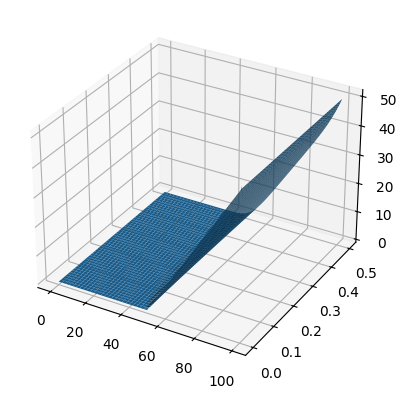

In [ ]:
#plot a 3d graph of value
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(x[:-1], t[:-1])
ax.plot_surface(Y, X, value.T)

### 4. Triangular finite elements


### a)

In [15]:
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D

In [16]:
h = 0.01
n = 100
x = [i*h for i in range(0,n+1)]
y = x

In [17]:
number_nodes = (n+1)**2
number_elements = 20000

In [31]:
def g(x, y):
    return x * (1 - y) + y * (1 - x)

def node_coord(i):
    x_index = i % 101
    if i == 101:
        x_index = i
    y_index = int(np.ceil(i/101))
    x_coord = x[x_index - 1]
    y_coord = 1-y[y_index - 1]
    return np.array([x_coord, y_coord])

def node_set(i):
    res = i%200
    if res%2 == 1:
        celda_v = (res+1)/2
    else:
        celda_v = res/2
    if celda_v == 0:
        celda_v = 100
    celda_h = int(np.ceil(i/200))
    l = int(celda_h)
    k = (celda_v)
    if i%2 == 1:
        return [int((l-1)*101+k), int((l-1)*101+k+1), int(l*101+k)]
    else:
        return [int(l*101+k+1), int((l-1)*101+k+1), int(l*101+k)]

def E(k):
    E = np.ones((3,3))
    nodos = node_set(k)
    coord_nodos = [node_coord(nodo) for nodo in nodos]
    for i in range(3):
        E[i, 0] = coord_nodos[i][0]
        E[i, 1] = coord_nodos[i][1]
    return E

def E_inv(k):
    mat = E(k)
    inv = np.zeros((3,3))
    inv[0] = np.array([mat[1,1]-mat[2,1], mat[2,1]-mat[0,1], mat[0,1]-mat[1,1]])
    inv[1] = np.array([mat[2,0]-mat[1,0], mat[0,0]-mat[2,0], mat[1,0]-mat[0,0]])
    inv[2] = np.array([mat[1,0]*mat[2,1]-mat[2,0]*mat[1,1], mat[2,0]*mat[0,1]-mat[0,0]*mat[2,1], mat[0,0]*mat[1,1]-mat[1,0]*mat[0,1]])
    inv = inv / (2/20000)
    return inv

def coef(k):
    inv = E_inv(k)
    a = inv[0]
    b = inv[1]
    return a, b

def A_k(k):
    mat = np.zeros((3, 3))
    a, b = coef(k)
    for i in range(3):
        for j in range(3):
            mat[i, j] = (1/20000) * (a[i]*a[j]+b[i]*b[j])
    return mat

In [32]:
A = np.zeros((number_nodes, number_nodes))
b = np.zeros(number_nodes)

for k in range(1, number_elements+1):
    Ak = A_k(k)
    nodos_k = node_set(k)
    for i in nodos_k:
        coords_i = node_coord(i)
        xi, yi = coords_i
        for j in nodos_k:
            i_index = nodos_k.index(i)
            j_index = nodos_k.index(j)
            A[i-1, j-1] += Ak[i_index, j_index]
            esq1, esq2, esq3, esq4 = [np.array([0, 0]), np.array([0, 1]), np.array([1, 0]), np.array([1, 1])]
        if esq1 in coords_i or esq2 in coords_i or esq3 in coords_i or esq4 in coords_i:
            A[i-1] = np.zeros(number_nodes)
            A[i-1, i-1] = 1
            b[i-1] = g(xi, yi)

In [36]:
x_sol = spsolve(A, b)

C:\Users\esteb\AppData\Local\Temp\ipykernel_10184\1993031211.py:1: SparseEfficiencyWarning:

spsolve requires A be CSC or CSR matrix format



In [37]:
import plotly.graph_objects as go

x_coords = []
y_coords = []
z_coords = []

for i in range(1, number_nodes + 1):
    coords = node_coord(i)
    x_coords.append(coords[0])
    y_coords.append(coords[1])
    z_coords.append(x_sol[i - 1])

fig = go.Figure(data=[go.Scatter3d(
    x=x_coords,
    y=y_coords,
    z=z_coords,
    mode='markers',
    marker=dict(
        size=5,
        color='red',  # Marker color
        opacity=0.8
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='u(x, y)'
    ),
    title='Interactive 3D Plot'
)

fig.show()

